In [16]:
#standard Imports
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.preprocessing as image
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.utils.vis_utils import plot_model
import cv2
import tifffile as tifi
import gc
import os
import math
import matplotlib.pyplot as plt

#### provided images are extremely large and most of the area is empty space. 
#### Tiling approach can alleviate this problem. In this notebook, I try to "compress" images to reduce empty space via seam carving. 
##### Seam carving is an algorithm for content-aware image resizing, where we can reduce (or increase) the size of an image by repeatedly carving out "seams" in one direction. 
#### Here, a seam is defined as an optimal 8-connected path of pixels on a single image from top to bottom, or left to right, where optimality is defined by an image energy function. 
#### I really like this algorithm because of effectiveness despite its simplicity.

In [2]:
# CNN Model
def buildCNNModel():

    model = keras.Sequential([
        layers.Conv2D(filters = 16, kernel_size = (3,3),input_shape = (1,128,128,4), padding = 'same', activation = 'relu'),
        layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'),
        layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(2),
    ])

    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['accuracy'],
    )
    model.summary()
    return model

In [3]:
#  Class imbalance will duplicate 2 LAA images for every 1 LAA image
def fixClassImbalance(images, labels):
    imagesNew = []
    labelsNew = []
    for x in range(len(images)):
        imagesNew.append(images[x])                
        labelsNew.append(labels[x])
        if(labels[x] == 1): # LAA
            # Add two additional LAA due to class imbalance
            imagesNew.append(images[x])                
            labelsNew.append(labels[x])        
            imagesNew.append(images[x])                
            labelsNew.append(labels[x])  
    return imagesNew, labelsNew

In [4]:

# Loading images .
def loadimages(df_original):
    tf.config.run_functions_eagerly(True)
    images= []
    labels = []
    for x in range(int(df_original.shape[0])):
        #img_tmp = OpenSlide(img_path)
        img_path = "./data/train_jpg/"+df_original.image_id[x]+".jpg"
        #print(img_path)
        img_tmp = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_tmp = img_tmp/255
        img_tmp = np.reshape(img_tmp, [1, 128, 128, 4])
        label = df_original.label[x]
        if(label == "CE"):
            label = 0
        elif(label == "LAA"):
            label = 1
        images.append(img_tmp)                
        labels.append(label)
    
        #print(x)
        del img_tmp  # to free memory
        gc.collect() # to free memory
        #print(gc.collect())
    return images, labels
    

In [5]:
# Training the model
def trainModel(trainimages,  trainlabels, valimages, vallabels, model):
    early_stopping = EarlyStopping(
        min_delta = 0.1,
        patience = 5,
        restore_best_weights = True
    )
    history = model.fit(epochs=10, x = np.array(trainimages), y = np.array(trainlabels), 
                          validation_data=(np.array(valimages), np.array(vallabels)), 
                          callbacks = [early_stopping])
    return history
#history = model.fit(x = np.array(images),y = np.array(labels), callbacks = [early_stopping])

In [6]:
#Plotting graphs
def plot_loss_accuracy(history):

    plt.figure(1)
    # summarize history for accuracy
    plt.subplot(211)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='lower right')

    # summarize history for loss
    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

In [7]:
# Save model
def saveModel(model, filename):
  model.save(filename)

#Load saved model
def loadModel(df_original, filename):
  if (os.path.exists(filename)):
    print("Model:", filename, " exists")
    model = tf.keras.models.load_model(filename)
    return model
  else:
    print("Model:", filename, " Doesnt exists")
    images, labels = loadimages(df_original, False)
    print('X shape:', np.array(images).shape)
    print('Labels shape:', np.array(labels).shape)
    model = buildCNNModel()
    X_train,X_val,Y_train,Y_val=train_test_split(images,labels, test_size=0.2, random_state=42)
    print("Train samples:", division, " Validation samples:", (len(images) - division))
    history = trainModel(X_train, Y_train, X_val, Y_val, model)
    print(history.params)
    print(history.history.keys())
    print(history.history['accuracy'])
    hist_df = pd.DataFrame(history.history) 

    # or save to csv: 
    hist_csv_file = './data/history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
    
    plot_loss_accuracy(history)
    model.save(filename)
    return model

In [8]:
def getSinglePredictedMaxColumn (prediction):
    num_rows, num_cols = prediction.shape
    print(num_rows, num_cols)
    new_list = []
    for i in range(num_rows):
        column_list = list(prediction[i])
        max_index = column_list.index(max(column_list))
        new_list.append(max_index)

    return(new_list)

In [9]:
#Load the data
df_original = pd.read_csv('/home/bear/prakash/aai541/finalproject/data/train.csv')
df_test = pd.read_csv('/home/bear/prakash/aai541/finalproject/data/test.csv')
df_other = pd.read_csv('/home/bear/prakash/aai541/finalproject/data/other.csv')
df_original.shape
print("Train size:", len(df_original), "Train Patient Samples:", len(df_original.patient_id.unique()))
print("Test size:", len(df_test), "Test Patient Samples:", len(df_test.patient_id.unique()))
print("Other size:", len(df_other), "Other Patient Samples:", len(df_other.patient_id.unique()))

Train size: 754 Train Patient Samples: 632
Test size: 4 Test Patient Samples: 4
Other size: 396 Other Patient Samples: 336


In [10]:
#check loaded dataframe
print(df_original.head(5))
print(df_test.head(5))

   image_id  center_id patient_id  image_num label
0  006388_0         11     006388          0    CE
1  008e5c_0         11     008e5c          0    CE
2  00c058_0         11     00c058          0   LAA
3  01adc5_0         11     01adc5          0   LAA
4  026c97_0          4     026c97          0    CE
   image_id  center_id patient_id  image_num
0  006388_0         11     006388          0
1  008e5c_0         11     008e5c          0
2  00c058_0         11     00c058          0
3  01adc5_0         11     01adc5          0


In [11]:
#check the train size
print(df_original.shape[0])

754


In [12]:
images, labels = loadimages(df_original)

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size=0.1, random_state=1)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=1) # 0.25 x 0.8 = 0.2
print(len(X_train), len(X_val), len(X_test))
print(len(Y_train), len(Y_val), len(Y_test))

542 136 76
542 136 76


In [14]:
modelCNN1 = buildCNNModel()
historyCNN1 = trainModel(X_train, Y_train, X_val, Y_val, modelCNN1)
print(historyCNN1.params)
print(historyCNN1.history.keys())
print(historyCNN1.history['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 128, 128, 16)   592       
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 128, 128, 32)   4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 128, 128, 64)   18496     
                                                                 
 flatten (Flatten)           (None, 1048576)           0         
                                                                 
 dense (Dense)               (None, 128)               134217856 
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 2

/home/bear/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
17/17 [==============================] - 15s 470ms/step - loss: 5625.4644 - accuracy: 0.4446 - val_loss: 2.0694 - val_accuracy: 0.3015
Epoch 2/10
17/17 [==============================] - 5s 316ms/step - loss: 0.7675 - accuracy: 0.4373 - val_loss: 0.3035 - val_accuracy: 0.6765
Epoch 3/10
17/17 [==============================] - 4s 216ms/step - loss: 0.2630 - accuracy: 0.5369 - val_loss: 0.2305 - val_accuracy: 0.6985
Epoch 4/10
17/17 [==============================] - 4s 229ms/step - loss: 0.2244 - accuracy: 0.5517 - val_loss: 0.2288 - val_accuracy: 0.6985
Epoch 5/10
17/17 [==============================] - 4s 238ms/step - loss: 0.2360 - accuracy: 0.4649 - val_loss: 0.2400 - val_accuracy: 0.6985
Epoch 6/10
17/17 [==============================] - 4s 235ms/step - loss: 0.2252 - accuracy: 0.5369 - val_loss: 0.2310 - val_accuracy: 0.2868
Epoch 7/10
17/17 [==============================] - 5s 312ms/step - loss: 0.2312 - accuracy: 0.4373 - val_loss: 0.2228 - val_accuracy: 0.6618
{'

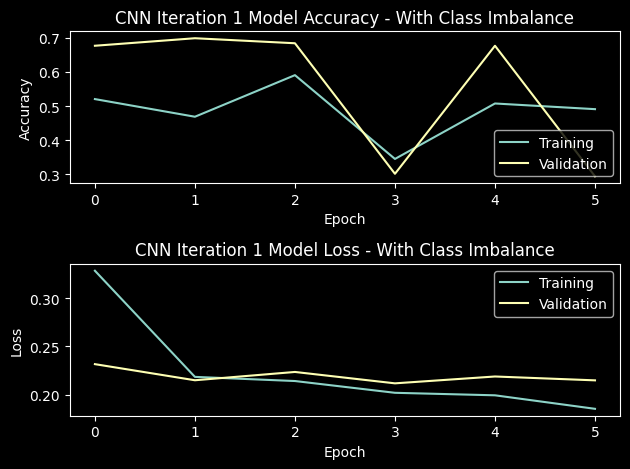

In [20]:

plt.style.use('dark_background')
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot([0.5203, 0.4686, 0.5904, 0.3450, 0.5074, 0.4908])
plt.plot([0.6765, 0.6985, 0.6838, 0.3015, 0.6765, 0.2941])
plt.title('CNN Iteration 1 Model Accuracy - With Class Imbalance')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

# summarize history for loss
plt.subplot(212)
plt.plot([0.3284, 0.2184, 0.2141, 0.2019, 0.1993, 0.1853])
plt.plot([0.2316, 0.2149, 0.2235, 0.2117, 0.2188, 0.2148])
plt.title('CNN Iteration 1 Model Loss - With Class Imbalance')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

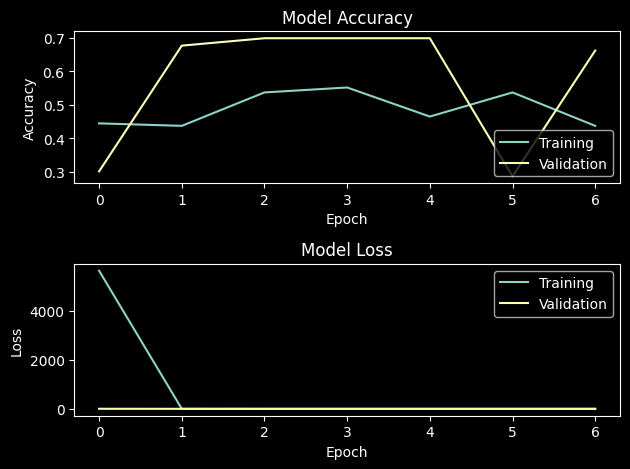

In [21]:
plot_loss_accuracy(historyCNN1)

In [22]:


Y_test_probs = modelCNN1.predict(np.array(X_test))
#pred_test = (pred_test >= 0.5).astype(np.int32)
Y_test_probs1 = getSinglePredictedMaxColumn(Y_test_probs)

print("Classification report for - \n{}:\n{}\n".format(
    modelCNN1, metrics.classification_report(Y_test, Y_test_probs1)))

2/3 [===================>..........] - ETA: 0s

/home/bear/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 0s 101ms/step
76 2
Classification report for - 
<keras.engine.sequential.Sequential object at 0x7f3569864820>:
              precision    recall  f1-score   support

           0       0.73      0.91      0.81        56
           1       0.17      0.05      0.08        20

    accuracy                           0.68        76
   macro avg       0.45      0.48      0.44        76
weighted avg       0.58      0.68      0.62        76




Confusion Matrix


Text(0.5, 25.722222222222214, 'Actual')

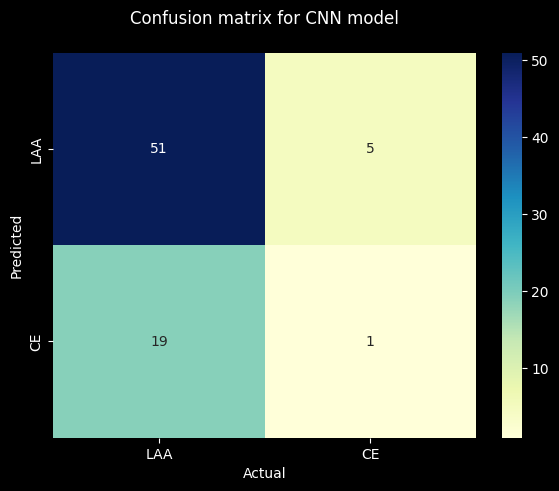

In [23]:
# Plot confusion matrices for benchmark and transfer learning models
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(15, 5))


print('Confusion Matrix')



cm = confusion_matrix(Y_test, Y_test_probs1)
df1_cm = pd.DataFrame(cm, index=['LAA', 'CE'], columns=['LAA', 'CE'])
plt.subplot(121)
plt.title("Confusion matrix for CNN model\n")
sns.heatmap(df1_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

In [11]:
#Test loading the model
model = loadModel(df_original, "./data/cnnmodel.h4")


Model: ./data/cnnmodel.h4  exists


In [12]:
# Make sure model is saved
print(os.path.exists("./data/cnnmodel.h4"))

True


In [31]:
# Load test pdf images
def loadTestImages(df_test):
    testimages= []
    for x in range(int(df_test.shape[0])):
        #img_tmp = OpenSlide(img_path)
        img_path = "./data/test_jpg/"+df_test.image_id[x]+".jpg"
        #print(img_path)
        img_tmp = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_tmp = img_tmp/255
        img_tmp = np.reshape(img_tmp, [1, 128, 128, 4])
        testimages.append(img_tmp)
        del img_tmp  # to free memory
        gc.collect() # to free memory
    return testimages

In [14]:
# Predic test images
testimages = loadTestImages(df_test)
print('test shape:', np.array(testimages).shape)

pred_test = model.predict(np.array(testimages))

test shape: (4, 1, 128, 128, 4)
1/1 [==============================] - 5s 5s/step


In [55]:
#print prediction probability
print(pred_test)

[[ 0.09765351  0.45385578]
 [-0.02298106  0.60735446]
 [ 0.04903571  0.4379663 ]
 [ 0.02032971  0.46669984]]


In [71]:
# Printing probability individually
for i in range(df_test.shape[0]):
    print (pred_test[i][0], pred_test[i][1] )

0.09765351 0.45385578
-0.022981055 0.60735446
0.049035713 0.4379663
0.020329714 0.46669984


In [76]:
# Preparing submission csv
preds = pd.DataFrame(np.concatenate(pred_test))
submission = pd.read_csv('./data/sample_submission.csv')
for i in range(df_test.shape[0]):
    submission.CE[i] = pred_test[i][0]
    submission.LAA[i] = pred_test[i][1]

submission = submission.groupby("patient_id").mean()
submission = submission[["CE", "LAA"]].round(6).reset_index()
submission

/tmp/ipykernel_311068/3744976746.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission.CE[i] = pred_test[i][0]
/tmp/ipykernel_311068/3744976746.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission.LAA[i] = pred_test[i][1]


,patient_id,CE,LAA
0,006388,0.097654,0.453856
1,008e5c,-0.022981,0.607354
2,00c058,0.049036,0.437966
3,01adc5,0.020330,0.466700


In [77]:
submission[["patient_id", "CE", "LAA"]].to_csv("./data/submission.csv", index=False)

!head submission.csv

head: cannot open 'submission.csv' for reading: No such file or directory


In [70]:
# Check to see loading model works
model2 = loadModel(df_original, "./data/cnnmodel.h4")

Model: ./data/cnnmodel.h4  exists


In [24]:
# Fixing class imbalance
imagesC = images
labelsC = labels
#imagesC, labelsC = loadimages(df_original)
print('X shape:', np.array(imagesC).shape)
print('Labels shape:', np.array(labelsC).shape)

X shape: (754, 1, 128, 128, 4)
Labels shape: (754,)


In [25]:
modelCNN2 = buildCNNModel()
XC_train, XC_test, YC_train, YC_test = train_test_split(imagesC, labelsC, test_size=0.1, random_state=1)
XC_train, XC_val, YC_train, YC_val = train_test_split(XC_train, YC_train, test_size=0.2, random_state=1) # 0.25 x 0.8 = 0.2
print(len(XC_train), len(XC_val), len(XC_test))
print(len(YC_train), len(YC_val), len(YC_test))
XC_train, YC_train = fixClassImbalance(XC_train, YC_train)
print(len(XC_train),len(YC_train))

historyCNN2 = trainModel(XC_train, YC_train, XC_val, YC_val, modelCNN2)
print(historyCNN2.params)
print(historyCNN2.history.keys())
print(historyCNN2.history['accuracy'])
histC_df = pd.DataFrame(historyCNN2.history) 


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 1, 128, 128, 16)   592       
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 128, 128, 32)   4640      
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 128, 128, 64)   18496     
                                                                 
 flatten_1 (Flatten)         (None, 1048576)           0         
                                                                 
 dense_2 (Dense)             (None, 128)               134217856 
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                

/home/bear/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
27/27 [==============================] - 8s 309ms/step - loss: 2470.8833 - accuracy: 0.4808 - val_loss: 2.1025 - val_accuracy: 0.3015
Epoch 2/10
27/27 [==============================] - 7s 267ms/step - loss: 0.4629 - accuracy: 0.4820 - val_loss: 0.2137 - val_accuracy: 0.6985
Epoch 3/10
27/27 [==============================] - 6s 226ms/step - loss: 0.2346 - accuracy: 0.5336 - val_loss: 0.2141 - val_accuracy: 0.3088
Epoch 4/10
27/27 [==============================] - 6s 218ms/step - loss: 0.1447 - accuracy: 0.5492 - val_loss: 0.2373 - val_accuracy: 0.3382
Epoch 5/10
27/27 [==============================] - 5s 200ms/step - loss: 0.1094 - accuracy: 0.5312 - val_loss: 0.2182 - val_accuracy: 0.5735
Epoch 6/10
27/27 [==============================] - 6s 223ms/step - loss: 0.0762 - accuracy: 0.5312 - val_loss: 0.2212 - val_accuracy: 0.5441
Epoch 7/10
27/27 [==============================] - 7s 249ms/step - loss: 0.0734 - accuracy: 0.4005 - val_loss: 0.3402 - val_accuracy: 0.6912
{'v

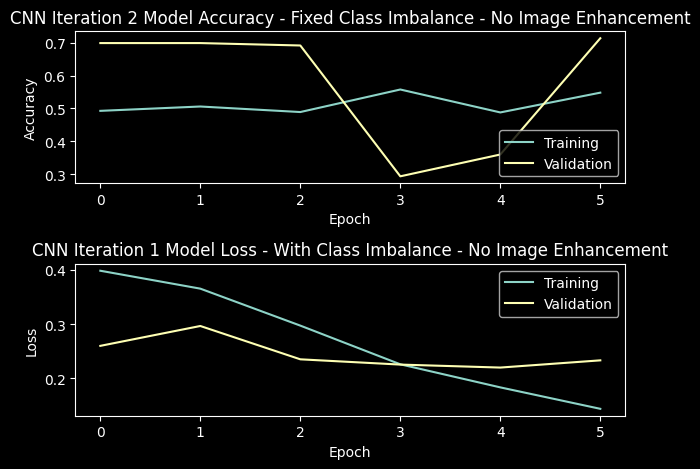

In [26]:

plt.style.use('dark_background')
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot([0.4928, 0.5060, 0.4892, 0.5576, 0.4880, 0.5480])
plt.plot([0.6985, 0.6985, 0.6912, 0.2941, 0.3603, 0.7132])
plt.title('CNN Iteration 2 Model Accuracy - Fixed Class Imbalance - No Image Enhancement')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

# summarize history for loss
plt.subplot(212)
plt.plot([0.3984, 0.3654, 0.2973, 0.2260, 0.1835, 0.1440])
plt.plot([0.2600, 0.2966, 0.2352, 0.2255, 0.2200, 0.2333])
plt.title('CNN Iteration 1 Model Loss - With Class Imbalance - No Image Enhancement')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

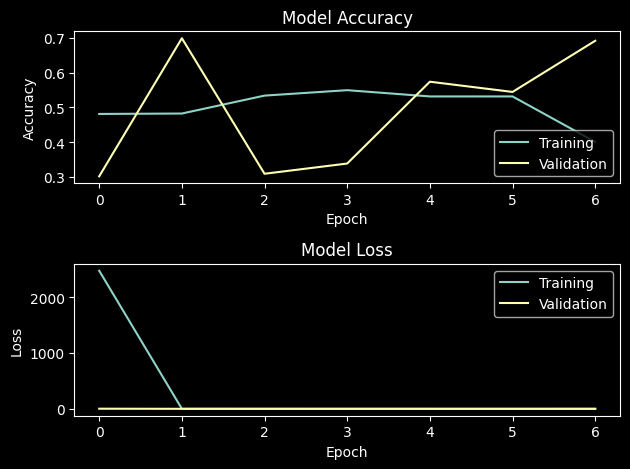

In [27]:
plot_loss_accuracy(historyCNN2)

In [28]:
YC_test_probs = modelCNN2.predict(np.array(XC_test))
#pred_test = (pred_test >= 0.5).astype(np.int32)
YC_test_probs1 = getSinglePredictedMaxColumn(YC_test_probs)
print("Classification report for - \n{}:\n{}\n".format(
    modelCNN2, metrics.classification_report(YC_test, YC_test_probs1)))

3/3 [==============================] - 0s 24ms/step


/home/bear/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/bear/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bear/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


76 2
Classification report for - 
<keras.engine.sequential.Sequential object at 0x7f36ae6b8d30>:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        56
           1       0.00      0.00      0.00        20

    accuracy                           0.74        76
   macro avg       0.37      0.50      0.42        76
weighted avg       0.54      0.74      0.63        76




/home/bear/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix


Text(0.5, 25.722222222222214, 'Actual')

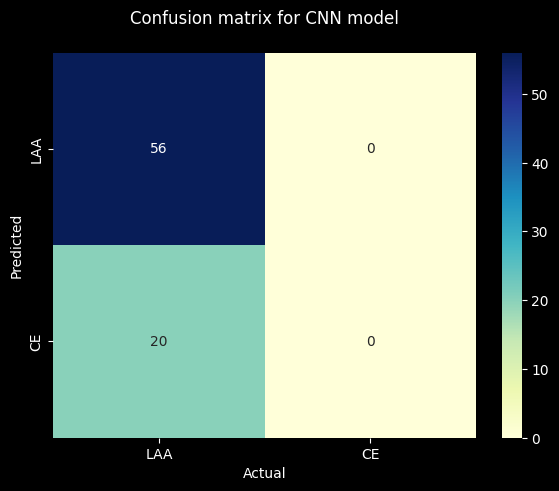

In [29]:
# Plot confusion matrices for benchmark and transfer learning models
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(15, 5))


print('Confusion Matrix')



cm = confusion_matrix(YC_test, YC_test_probs1)
df1_cm = pd.DataFrame(cm, index=['LAA', 'CE'], columns=['LAA', 'CE'])
plt.subplot(121)
plt.title("Confusion matrix for CNN model\n")
sns.heatmap(df1_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

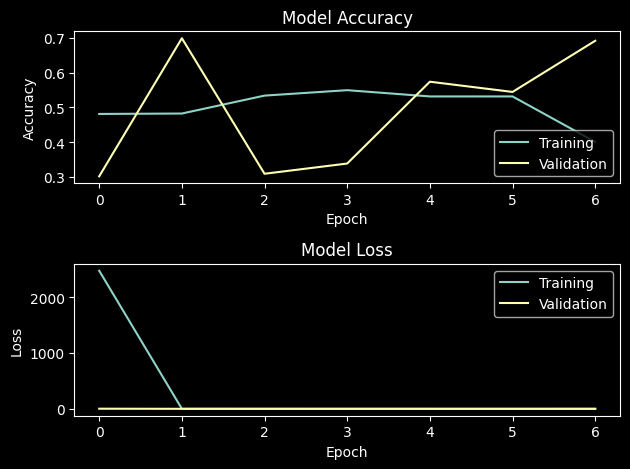

4
test shape: (4, 1, 128, 128, 4)


/home/bear/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 413ms/step
[[0.34618798 0.19094603]
 [0.19269565 0.18890506]
 [0.42124048 0.3606881 ]
 [0.42148647 0.34195197]]


In [32]:
plot_loss_accuracy(historyCNN2)
testimages = loadTestImages(df_test)
print(len(testimages))
print('test shape:', np.array(testimages).shape)

predC_test = modelCNN2.predict(np.array(testimages))
print(predC_test)

In [34]:
tf.config.run_functions_eagerly(True)
images3= []
labels3 = []
for x in range(int(df_original.shape[0])):
    #img_tmp = OpenSlide(img_path)
    img_path = "./data/train_jpg2/"+df_original.image_id[x]+".jpg"
    #print(img_path)
    img_tmp = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_tmp = img_tmp/255
    img_tmp = np.reshape(img_tmp, [1, 128, 128, 4])
    label = df_original.label[x]
    if(label == "CE"):
        label = 0
    elif(label == "LAA"):
        label = 1
      
    images3.append(img_tmp)                
    labels3.append(label)
    
    #print(x)
    del img_tmp  # to free memory
    gc.collect() # to free memory
print('X shape:', np.array(images3).shape)
print('Labels shape:', np.array(labels3).shape)

X shape: (754, 1, 128, 128, 4)
Labels shape: (754,)


In [40]:
## Splitting data
#XO_train,XO_val,YO_train,YO_val=train_test_split(images,labels, test_size=0.2, random_state=42)
XO_train, XO_test, YO_train, YO_test = train_test_split(images3, labels3, test_size=0.1, random_state=42)
XO_train, XO_val, YO_train, YO_val = train_test_split(XO_train, YO_train, test_size=0.2, random_state=42) # 0.25 x 0.8 = 0.2
print(len(XO_train), len(XO_val), len(XO_test))
print(len(YO_train), len(YO_val), len(YO_test))

XO_train, YO_train = fixClassImbalance(XO_train, YO_train)
print(len(XO_train),len(YO_train))

542 136 76
542 136 76
836 836


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 1, 128, 128, 16)   592       
                                                                 
 conv2d_10 (Conv2D)          (None, 1, 128, 128, 32)   4640      
                                                                 
 conv2d_11 (Conv2D)          (None, 1, 128, 128, 64)   18496     
                                                                 
 flatten_3 (Flatten)         (None, 1048576)           0         
                                                                 
 dense_6 (Dense)             (None, 128)               134217856 
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 2)                

/home/bear/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
27/27 [==============================] - 25s 941ms/step - loss: 5606.7183 - accuracy: 0.4868 - val_loss: 0.2073 - val_accuracy: 0.2353
Epoch 2/10
27/27 [==============================] - 25s 922ms/step - loss: 0.4170 - accuracy: 0.4880 - val_loss: 0.2357 - val_accuracy: 0.2353
Epoch 3/10
27/27 [==============================] - 25s 932ms/step - loss: 0.3608 - accuracy: 0.4952 - val_loss: 0.1979 - val_accuracy: 0.2353
Epoch 4/10
27/27 [==============================] - 25s 923ms/step - loss: 0.3499 - accuracy: 0.4868 - val_loss: 0.2040 - val_accuracy: 0.7353
Epoch 5/10
27/27 [==============================] - 25s 937ms/step - loss: 0.3121 - accuracy: 0.4055 - val_loss: 0.2040 - val_accuracy: 0.7574
Epoch 6/10
27/27 [==============================] - 25s 917ms/step - loss: 0.2877 - accuracy: 0.4450 - val_loss: 0.1933 - val_accuracy: 0.7500
Epoch 7/10
27/27 [==============================] - 25s 929ms/step - loss: 0.2658 - accuracy: 0.3959 - val_loss: 0.2078 - val_accuracy: 0.2

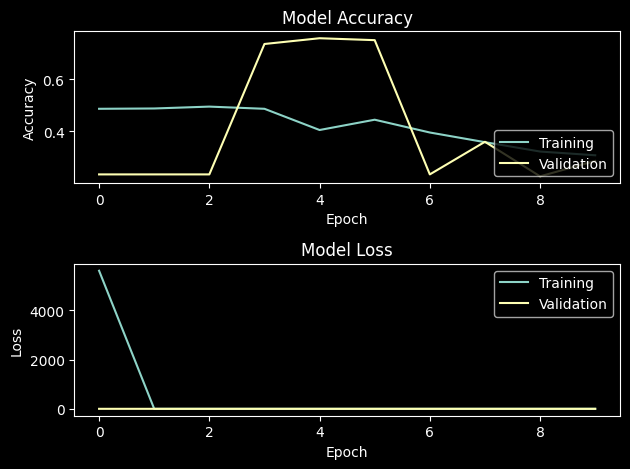

In [41]:
modelOpt = buildCNNModel()

historyOpt = modelOpt.fit(epochs=10, x = np.array(XO_train), y = np.array(YO_train), 
                          validation_data=(np.array(XO_val), np.array(YO_val))) 
                          #, callbacks = [early_stopping])
#historyOpt = trainModel(images, labels, modelOpt)
plot_loss_accuracy(historyOpt)

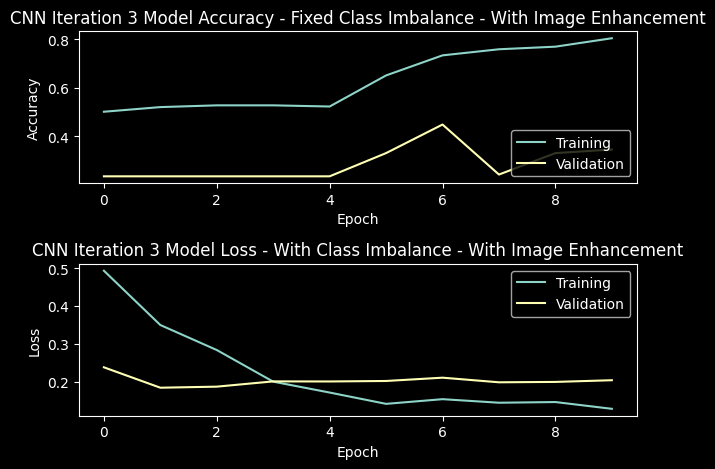

In [42]:
plt.style.use('dark_background')
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot([0.5012, 0.5203, 0.5275, 0.5275, 0.5227, 0.6507, 0.7333, 0.7584, 0.7691, 0.8038])
plt.plot([0.2353, 0.2353, 0.2353, 0.2353, 0.2353, 0.3309, 0.4485, 0.2426, 0.3309, 0.3456])
plt.title('CNN Iteration 3 Model Accuracy - Fixed Class Imbalance - With Image Enhancement')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

# summarize history for loss
plt.subplot(212)
plt.plot([0.4928, 0.3493, 0.2832, 0.1996, 0.1708, 0.1409, 0.1533, 0.1439, 0.1457, 0.1278])
plt.plot([0.2375, 0.1836, 0.1864, 0.2003, 0.2001, 0.2014, 0.2101, 0.1979, 0.1989, 0.2034])
plt.title('CNN Iteration 3 Model Loss - With Class Imbalance - With Image Enhancement')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [43]:
# Predic test images


print('test shape:', np.array(XO_test).shape)

pred_test = modelOpt.predict(np.array(XO_test))

newpred = getSinglePredictedMaxColumn(pred_test)
print(newpred[1:5])


print("Classification report for - \n{}:\n{}\n".format(
    modelOpt, metrics.classification_report(YO_test, newpred)))



test shape: (76, 1, 128, 128, 4)
1/3 [=========>....................] - ETA: 0s

/home/bear/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 0s 98ms/step
76 2
[1, 1, 1, 1]
Classification report for - 
<keras.engine.sequential.Sequential object at 0x7f36ae53c670>:
              precision    recall  f1-score   support

           0       0.43      0.06      0.11        48
           1       0.35      0.86      0.49        28

    accuracy                           0.36        76
   macro avg       0.39      0.46      0.30        76
weighted avg       0.40      0.36      0.25        76




Confusion Matrix


Text(0.5, 25.722222222222214, 'Actual')

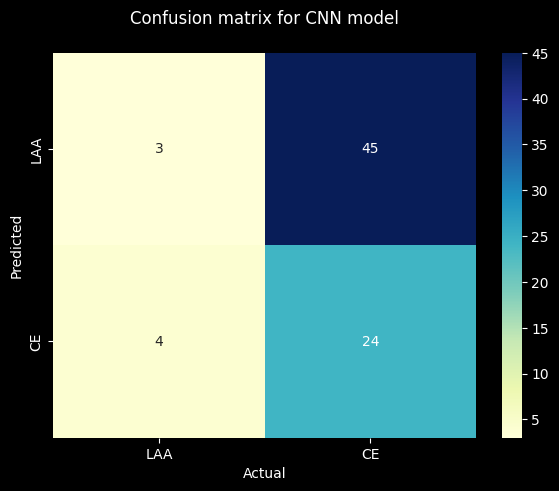

In [44]:
# Plot confusion matrices for benchmark and transfer learning models
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(15, 5))


print('Confusion Matrix')


#pred_test = (pred_test >= 0.5).astype(np.int32)

cm = confusion_matrix(YO_test, newpred)
df_cm = pd.DataFrame(cm, index=['LAA', 'CE'], columns=['LAA', 'CE'])
plt.subplot(121)
plt.title("Confusion matrix for CNN model\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

In [45]:
## Splitting data
#XO_train,XO_val,YO_train,YO_val=train_test_split(images,labels, test_size=0.2, random_state=42)
XO1_train, XO1_test, YO1_train, YO1_test = train_test_split(images3, labels3, test_size=0.1, random_state=42)
XO1_train, XO1_val, YO1_train, YO1_val = train_test_split(XO1_train, YO1_train, test_size=0.2, random_state=42) # 0.25 x 0.8 = 0.2
print(len(XO1_train), len(XO1_val), len(XO1_test))
print(len(YO1_train), len(YO1_val), len(YO1_test))

542 136 76
542 136 76


In [46]:
# Earlystopping
modelOpt2 = buildCNNModel()
historyOpt2 = trainModel(XO1_train, YO1_train, XO1_val, YO1_val, modelOpt2)
print(historyOpt2.params)
print(historyOpt2.history.keys())
print(historyOpt2.history['accuracy'])


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 1, 128, 128, 16)   592       
                                                                 
 conv2d_13 (Conv2D)          (None, 1, 128, 128, 32)   4640      
                                                                 
 conv2d_14 (Conv2D)          (None, 1, 128, 128, 64)   18496     
                                                                 
 flatten_4 (Flatten)         (None, 1048576)           0         
                                                                 
 dense_8 (Dense)             (None, 128)               134217856 
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 2)                

/home/bear/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
17/17 [==============================] - 19s 1s/step - loss: 4528.9189 - accuracy: 0.4908 - val_loss: 0.2422 - val_accuracy: 0.2353
Epoch 2/10
17/17 [==============================] - 16s 938ms/step - loss: 0.2669 - accuracy: 0.3487 - val_loss: 0.1837 - val_accuracy: 0.2353
Epoch 3/10
17/17 [==============================] - 16s 942ms/step - loss: 0.1860 - accuracy: 0.4705 - val_loss: 0.1877 - val_accuracy: 0.2353
Epoch 4/10
17/17 [==============================] - 16s 947ms/step - loss: 0.1581 - accuracy: 0.5240 - val_loss: 0.2032 - val_accuracy: 0.3088
Epoch 5/10
17/17 [==============================] - 16s 946ms/step - loss: 0.1278 - accuracy: 0.6218 - val_loss: 0.1990 - val_accuracy: 0.2794
Epoch 6/10
17/17 [==============================] - 17s 994ms/step - loss: 0.0841 - accuracy: 0.7288 - val_loss: 0.1922 - val_accuracy: 0.7206
{'verbose': 1, 'epochs': 10, 'steps': 17}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
[0.49077489972114563, 0.3487084805965423

In [47]:
gc.collect()

26394

In [48]:
print('test shape:', np.array(XO1_test).shape)

pred_test2 = modelOpt2.predict(np.array(XO1_test))
print(len(pred_test2), pred_test2[2])

newpred2 = getSinglePredictedMaxColumn(pred_test2)
print(newpred2[1:5])

test shape: (76, 1, 128, 128, 4)
3/3 [==============================] - 0s 44ms/step
76 [-0.03916288  0.05413111]
76 2
[1, 1, 1, 1]


Confusion Matrix
Classification report for - 
<keras.engine.sequential.Sequential object at 0x7f35bca59240>:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        48
           1       0.37      1.00      0.54        28

    accuracy                           0.37        76
   macro avg       0.18      0.50      0.27        76
weighted avg       0.14      0.37      0.20        76




/home/bear/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bear/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bear/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


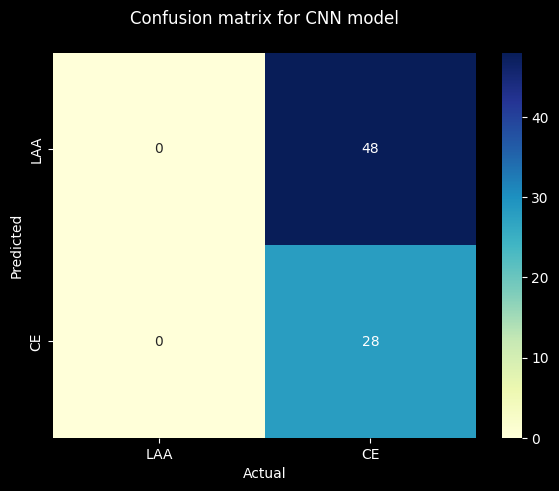

In [51]:
# Plot confusion matrices for benchmark and transfer learning models
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(15, 5))


print('Confusion Matrix')


#pred_test = (pred_test >= 0.5).astype(np.int32)

cm = confusion_matrix(YO1_test, newpred2)
df_cm = pd.DataFrame(cm, index=['LAA', 'CE'], columns=['LAA', 'CE'])
plt.subplot(121)
plt.title("Confusion matrix for CNN model\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")
print("Classification report for - \n{}:\n{}\n".format(
    modelOpt2, metrics.classification_report(YO_test, newpred2)))